In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

In [2]:
ratings = pd.read_csv("data/ratings.csv")

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
ratings.shape

(100004, 4)

In [5]:
users = len(ratings.userId.unique())
movies = len(ratings.movieId.unique())
print(users, movies)

671 9066


In [6]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [7]:
movieId_to_seqId = {}
seqId_to_movieId = {}
for sId, id in enumerate(ratings["movieId"].unique()):
    seqId_to_movieId[sId] = id
    movieId_to_seqId[id] = sId
    
def return_movieId_to_seqId(row):
  return movieId_to_seqId[row.movieId]

ratings["new_movieId"] = ratings.apply(return_movieId_to_seqId, axis=1)

In [9]:
ratings.describe()

,userId,movieId,rating,timestamp,new_movieId
count,100004.000000,100004.000000,100004.000000,1.000040e+05,100004.000000
mean,347.011310,12548.664363,3.543608,1.129639e+09,1660.778349
std,195.163838,26369.198969,1.058064,1.916858e+08,1893.955817
min,1.000000,1.000000,0.500000,7.896520e+08,0.000000
25%,182.000000,1028.000000,3.000000,9.658478e+08,327.000000
50%,367.000000,2406.500000,4.000000,1.110422e+09,873.000000
75%,520.000000,5418.000000,4.000000,1.296192e+09,2344.000000
max,671.000000,163949.000000,5.000000,1.476641e+09,9065.000000


In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2, random_state = 42)

In [11]:
train.head()

,userId,movieId,rating,timestamp,new_movieId
37865,273,5816,4.5,1466946328,364
46342,339,2028,4.5,1446663181,113
64614,461,3895,0.5,1093224965,4626
41974,300,3578,4.5,1086010878,468
50236,369,292,3.0,847465462,48


In [12]:
test.head()

,userId,movieId,rating,timestamp,new_movieId
19090,128,1028,5.0,1049690908,165
99678,665,4736,1.0,1010197684,9064
18455,120,4002,3.0,1167420604,2763
35755,257,1274,4.0,1348544094,2190
66536,468,6440,4.0,1296191715,1333


In [13]:
""" 영화 레이어 """
movie_input = Input(shape=[1], name='Movies')
# Embedding(input_dim, output_dim)
# - input_dim: 단어의 수 (여기서는 영화의 수)
#   - 정확히는 가장 큰 인덱스+1. 인덱스가 0부터 시작한다면 단어의 수가 됨. 인덱스가 1부터 시작하면 단어의 수+1이 됨
# - output_dim: 임베딩 레이어 출력 차원
movie_embedding = Embedding(movies+1, 5, name='Embedded_Movies')(movie_input) # 임베딩의 결과는 2차원
movie_final = Flatten(name='Flatten_Movies')(movie_embedding) # 내적을 하기 위해 1차원으로 플랫

In [14]:
""" 사용자 레이어 """
user_input = Input(shape=[1], name='Users')
user_embedding = Embedding(users+1, 5, name='Embedded_Users')(user_input)
user_final = Flatten(name='Flatten_Users')(user_embedding)

In [15]:
""" 내적 레이어 """
mult = Dot(name='Dot_Product', axes=1)([movie_final, user_final])

In [16]:
import tensorflow as tf

In [17]:
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(mean_squared_error(y_true, y_pred))

model = Model([movie_input,user_input], mult)
model.compile(optimizer='adam', loss=root_mean_squared_error)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Movies (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Users (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedded_Movies     │ (None, 1, 5)      │     45,335 │ Movies[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedded_Users      │ (None, 1, 5)      │      3,360 │ Users[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten_Movies      │ (None, 5)         │          0 │ Embedded_Movies[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten_Users       │ (None, 5)         │          0 │ Embedded_Users[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_Product (Dot)   │ (None, 1)         │          0 │ Flatten_Movies[0… │
│                     │                   │            │ Flatten_Users[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,695 (190.21 KB)

 Trainable params: 48,695 (190.21 KB)

 Non-trainable params: 0 (0.00 B)

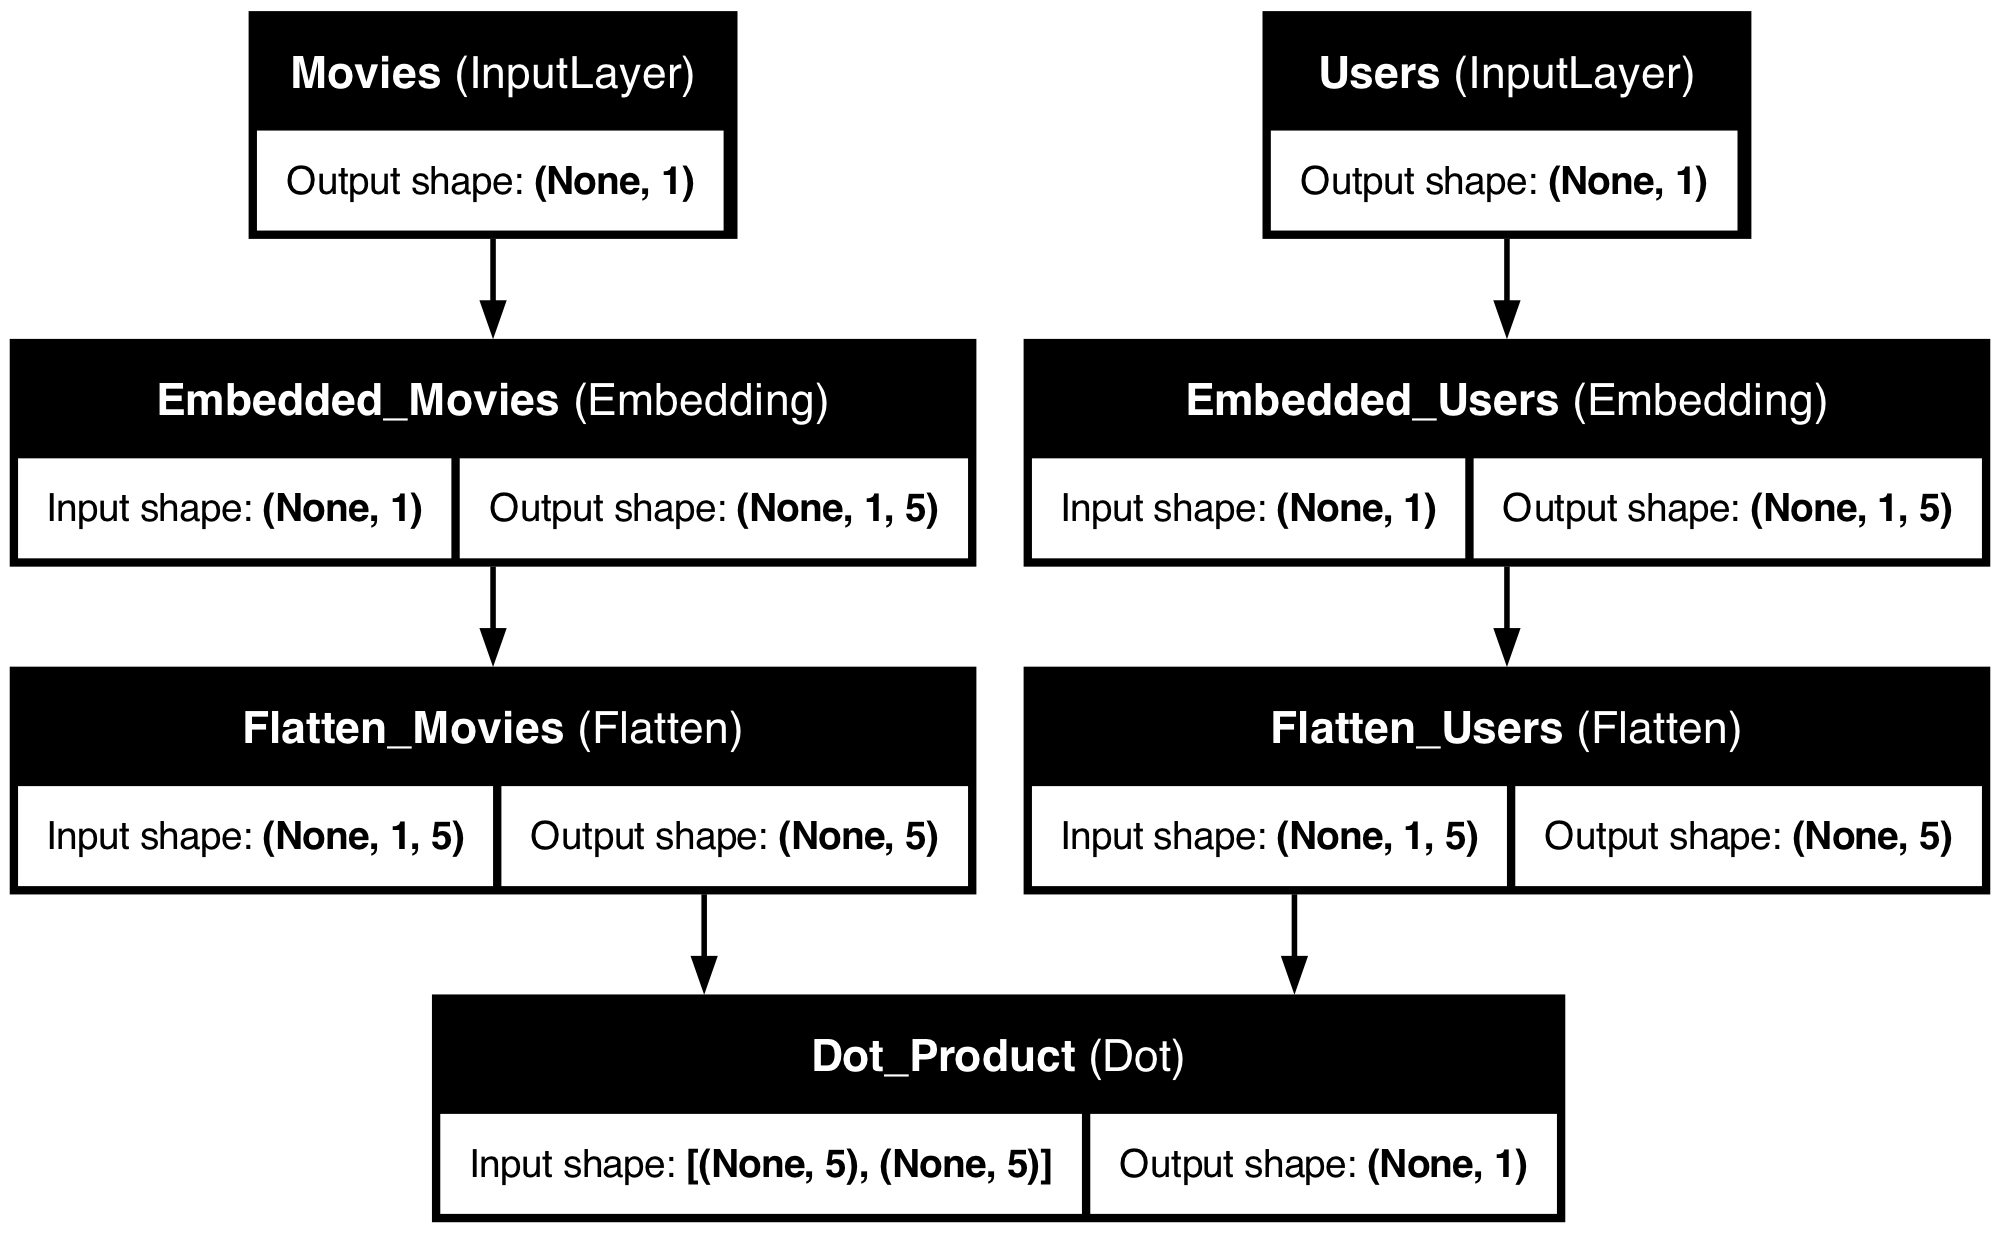

In [18]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/10


/Users/yunjaecho/Git/recommender_system/env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Movies', 'Users']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step - loss: 3.4897
Epoch 2/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - loss: 2.2040
Epoch 3/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 297us/step - loss: 1.3444
Epoch 4/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step - loss: 1.0293
Epoch 5/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - loss: 0.8801
Epoch 6/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step - loss: 0.8055
Epoch 7/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step - loss: 0.7517
Epoch 8/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - loss: 0.7228
Epoch 9/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 287us/step - loss: 0.6959
Epoch 10/10
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - loss: 0.6713


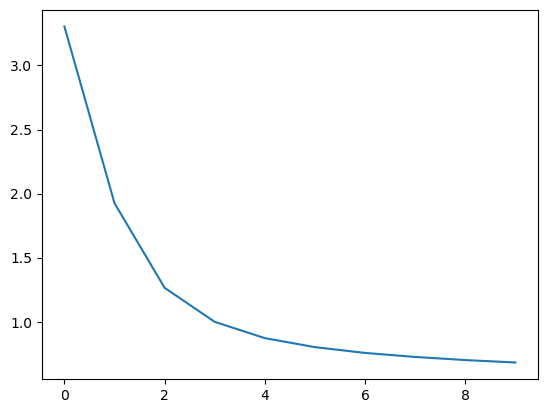

In [19]:
from keras.models import load_model

history = model.fit([train.new_movieId, train.userId], train.rating, epochs=10, verbose=1)
model.save(r'recommender_model.h5')
plt.plot(history.history['loss'])
plt.xlabel = ('Epochs')
plt.ylabel = ("Training_Error")

In [20]:
model.evaluate([test.new_movieId, test.userId], test.rating)

254/626 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step - loss: 0.8045

/Users/yunjaecho/Git/recommender_system/env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Movies', 'Users']. Received: the structure of inputs=('*', '*')
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.8103


0.8131617903709412

In [21]:
predictions = model.predict([test.new_movieId.head(8), test.userId.head(8)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [22]:
print(predictions)

[[ 4.7707257 ]
 [ 0.0443801 ]
 [ 3.2997017 ]
 [ 3.9075224 ]
 [ 3.0368178 ]
 [ 4.003005  ]
 [ 3.6880794 ]
 [-0.10206796]]


In [23]:
for i in range(0,8):
  print(predictions[i], test.rating.iloc[i])

[4.7707257] 5.0
[0.0443801] 1.0
[3.2997017] 3.0
[3.9075224] 4.0
[3.0368178] 4.0
[4.003005] 5.0
[3.6880794] 5.0
[-0.10206796] 4.0
